# Data Collection

In [2]:
import sys
sys.path.append('../')
from src.data_collection import get_data_from_wiki
from src.database.mongo import get_topics_from_mongo

In [11]:
# enriched_topics = await get_data_from_wiki(limit=5, domain="programming", save_to_mongo=False)
enriched_topics = await get_topics_from_mongo(limit=150, domain="programming")
enriched_topics[0].keys()

dict_keys(['_id', 'domain', 'id', 'categories', 'content', 'description', 'properties', 'sections', 'summary', 'title', 'topic_type', 'url', 'wikidata_url', 'embedding_refs', 'embedding_error'])

# Embed and Store

In [12]:
from src.embeddings import generate_embedding as embed_text
from src.embeddings import generate_embeddings_batch_async as embed_text_batch
from time import time
#for topic in enriched_topics:
#    topic["embedding"] = embed_text(topic["content"])

# Batch process
# Extract content from all topics
contents = [topic["content"] for topic in enriched_topics]

start_time = time()
# Generate embeddings in batch
embeddings = await embed_text_batch(contents)


# Assign embeddings back to topics
for i, topic in enumerate(enriched_topics):
    topic["embedding"] = embeddings[i]

print(f"Generated embeddings for {len(enriched_topics)} topics in {time() - start_time:.2f} seconds.")


Generated embeddings for 150 topics in 144.36 seconds.


In [ ]:
enriched_topics

In [5]:
# from src.database.chromadb import ChromaDBClient

# vector_db = ChromaDBClient()
# collection = vector_db.get_or_create_collection("attempt1_programming")
# collection.delete(ids=[topic["id"] for topic in enriched_topics])
# for topic in enriched_topics:
#     collection.add(
#         documents=[topic["content"]],
#         metadatas=[{"title": topic["title"], "domain": topic["domain"]}],
#         ids=[topic["id"]],
#         embeddings=topic["embedding"],
#     )

# collection.count()  # Check the number of documents in the collection

# Plot and Visualize using PCA

In [13]:
# PCA
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd

Skipping topic Singularity due to missing embedding.
Computing t-SNE (this may take a while for 1000 points)...


g:\Projects\learning_path\.venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



Total explained variance with 3 PCA components: 0.19


C:\Users\mnand\AppData\Local\Temp\ipykernel_22784\3691984097.py:98: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



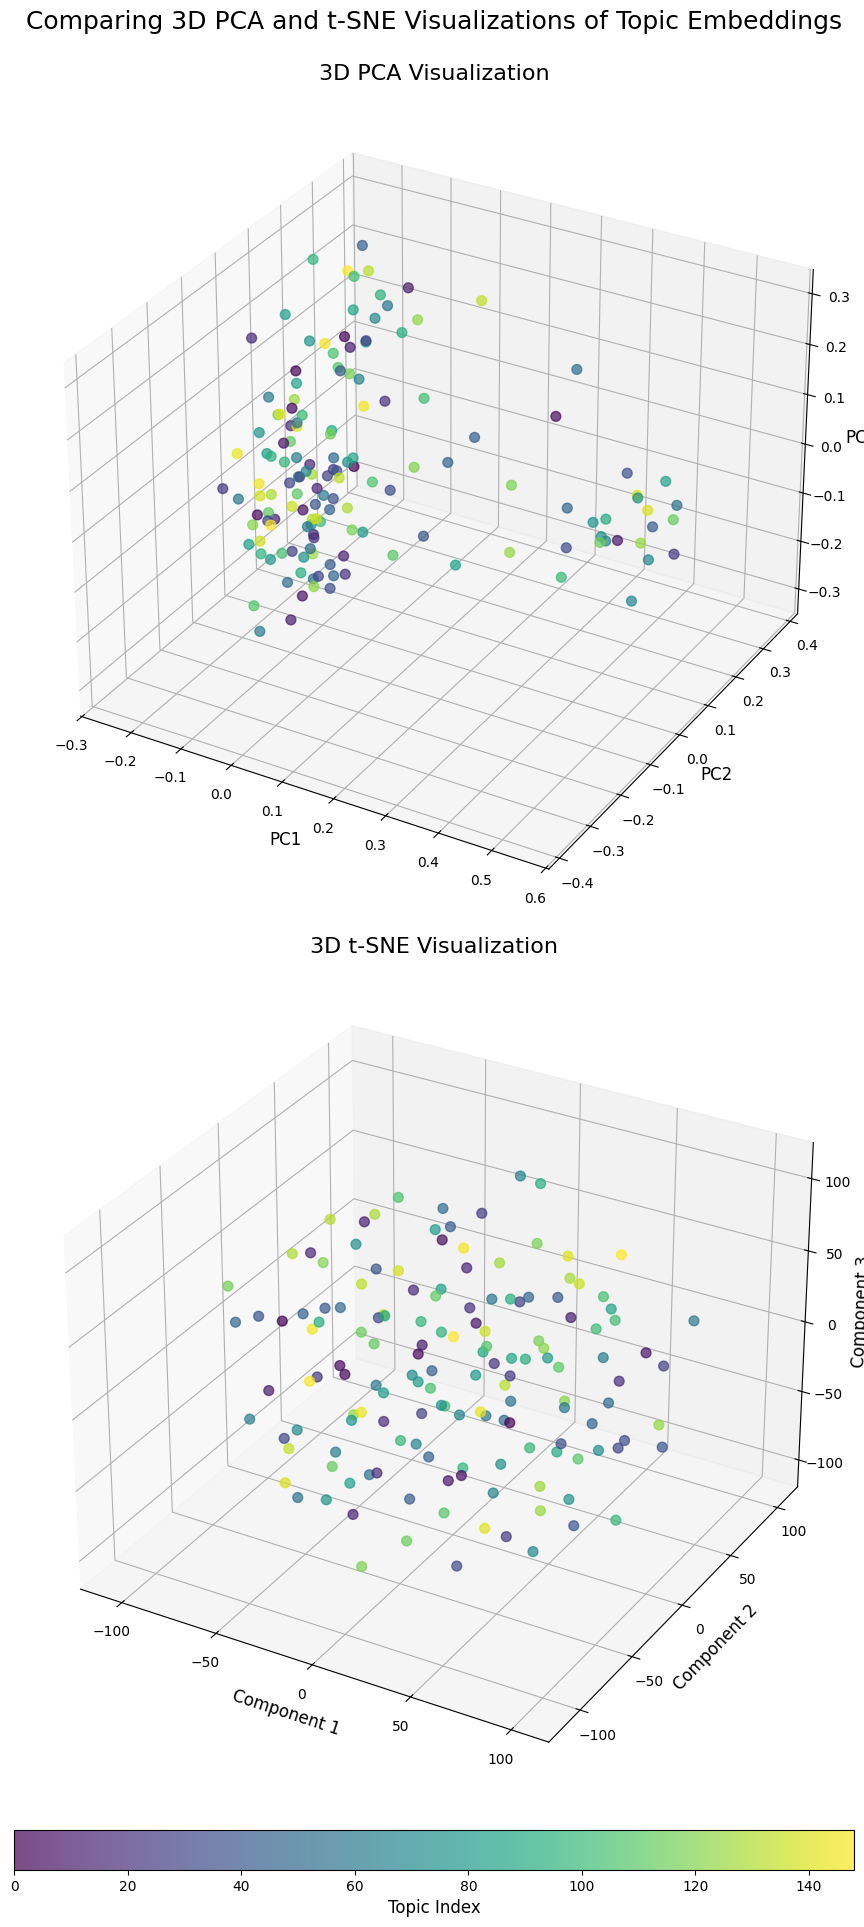

In [15]:
# Extract embeddings and metadata from enriched_topics
embeddings = []
titles = []
domains = []

for topic in enriched_topics:
    if not topic["embedding"]:
        print(f"Skipping topic {topic['title']} due to missing embedding.")
        continue
    embeddings.append(topic["embedding"][0])  # The embeddings are nested in a list
    titles.append(topic["title"])
    domains.append(topic["domain"])

# Convert to numpy array
embeddings_array = np.array(embeddings)

# Create a figure with two subplots stacked vertically
fig = plt.figure(figsize=(12, 20))
# Adjust bottom for colorbar space
fig.subplots_adjust(bottom=0.1)

# 1. PCA 3D VISUALIZATION - TOP SUBPLOT
pca_3d = PCA(n_components=3)
pca_result_3d = pca_3d.fit_transform(embeddings_array)

ax1 = fig.add_subplot(211, projection='3d')
scatter_pca = ax1.scatter(
    pca_result_3d[:, 0], 
    pca_result_3d[:, 1], 
    pca_result_3d[:, 2],
    c=np.arange(len(embeddings)),
    cmap='viridis',
    s=50, 
    alpha=0.7
)

ax1.set_title('3D PCA Visualization', fontsize=16)
ax1.set_xlabel('PC1', fontsize=12)
ax1.set_ylabel('PC2', fontsize=12)
ax1.set_zlabel('PC3', fontsize=12)

# 2. t-SNE 3D VISUALIZATION - BOTTOM SUBPLOT
print("Computing t-SNE (this may take a while for 1000 points)...")

tsne_3d = TSNE(
    n_components=3, 
    perplexity=min(30, len(embeddings)-1),
    random_state=42, 
    n_iter=1000,
    learning_rate='auto',
    init='pca'
)
tsne_result_3d = tsne_3d.fit_transform(embeddings_array)

ax2 = fig.add_subplot(212, projection='3d')
scatter_tsne = ax2.scatter(
    tsne_result_3d[:, 0], 
    tsne_result_3d[:, 1], 
    tsne_result_3d[:, 2],
    c=np.arange(len(embeddings)),
    cmap='viridis',
    s=50, 
    alpha=0.7
)

ax2.set_title('3D t-SNE Visualization', fontsize=16)
ax2.set_xlabel('Component 1', fontsize=12)
ax2.set_ylabel('Component 2', fontsize=12)
ax2.set_zlabel('Component 3', fontsize=12)

# Create a horizontal colorbar at the bottom
cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.02])  # left, bottom, width, height
cbar = fig.colorbar(scatter_tsne, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Topic Index', fontsize=12)

plt.suptitle('Comparing 3D PCA and t-SNE Visualizations of Topic Embeddings', fontsize=18, y=0.98)

# Only add text labels if there are few points to reduce clutter
if len(embeddings) <= 50:
    for i, title in enumerate(titles):
        ax1.text(
            pca_result_3d[i, 0], 
            pca_result_3d[i, 1], 
            pca_result_3d[i, 2], 
            title, 
            size=8
        )
        ax2.text(
            tsne_result_3d[i, 0], 
            tsne_result_3d[i, 1], 
            tsne_result_3d[i, 2], 
            title, 
            size=8
        )

print(f"Total explained variance with 3 PCA components: {sum(pca_3d.explained_variance_ratio_):.2f}")

plt.tight_layout(rect=[0, 0.08, 1, 0.98])  # Adjust layout but leave space for colorbar
plt.show()

# Optional: Save clustered data for further analysis
visualization_data = pd.DataFrame({
    'title': titles,
    'domain': domains,
    'pca_x': pca_result_3d[:, 0],
    'pca_y': pca_result_3d[:, 1],
    'pca_z': pca_result_3d[:, 2],
    'tsne_x': tsne_result_3d[:, 0],
    'tsne_y': tsne_result_3d[:, 1],
    'tsne_z': tsne_result_3d[:, 2]
})

In [16]:
# Install necessary packages if needed
# !pip install plotly networkx scipy scikit-learn pandas

import networkx as nx
import plotly.graph_objects as go
from scipy.spatial import distance
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


# Apply dimensionality reduction
print("Applying PCA...")
pca_3d = PCA(n_components=3)
pca_result_3d = pca_3d.fit_transform(embeddings_array)

print("Computing t-SNE...")
tsne_3d = TSNE(
    n_components=3, 
    perplexity=min(3, len(embeddings)-1),
    random_state=42, 
    n_iter=500,
    learning_rate='auto',
    init='pca'
)
tsne_result_3d = tsne_3d.fit_transform(embeddings_array)

# Create a Pandas DataFrame for visualization
visualization_data = pd.DataFrame({
    'title': titles,
    'domain': domains,
    'pca_x': pca_result_3d[:, 0],
    'pca_y': pca_result_3d[:, 1],
    'pca_z': pca_result_3d[:, 2],
    'tsne_x': tsne_result_3d[:, 0],
    'tsne_y': tsne_result_3d[:, 1],
    'tsne_z': tsne_result_3d[:, 2]
})

# Create a NetworkX graph
G = nx.Graph()

# Add nodes with attributes
for i in range(len(visualization_data)):
    G.add_node(i, 
               title=visualization_data['title'][i], 
               domain=visualization_data['domain'][i],
               pca_pos=(visualization_data['pca_x'][i], visualization_data['pca_y'][i], visualization_data['pca_z'][i]),
               tsne_pos=(visualization_data['tsne_x'][i], visualization_data['tsne_y'][i], visualization_data['tsne_z'][i]))

# Add edges between similar nodes (using cosine similarity)
# Only connect nodes that are sufficiently similar to avoid a hairball
threshold = 0.8  # Adjust this threshold as needed
print("Computing edges based on cosine similarity...")
for i in range(len(embeddings)):
    for j in range(i+1, len(embeddings)):
        sim = 1 - distance.cosine(embeddings[i], embeddings[j])
        if sim > threshold:
            G.add_edge(i, j, weight=sim)

# Create interactive plots (one for PCA, one for t-SNE)
def create_3d_network_plot(G, pos_attr, title):
    # Extract node positions
    node_x = []
    node_y = []
    node_z = []
    node_text = []
    node_color = list(range(len(G.nodes())))
    
    for node in G.nodes():
        x, y, z = G.nodes[node][pos_attr]
        node_x.append(x)
        node_y.append(y)
        node_z.append(z)
        node_text.append(f"Title: {G.nodes[node]['title']}<br>Domain: {G.nodes[node]['domain']}")
    
    # Create edges
    edge_x = []
    edge_y = []
    edge_z = []
    
    for edge in G.edges():
        x0, y0, z0 = G.nodes[edge[0]][pos_attr]
        x1, y1, z1 = G.nodes[edge[1]][pos_attr]
        # Add None to create a break in the line
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
        edge_z.extend([z0, z1, None])
    
    # Create edge trace
    edge_trace = go.Scatter3d(
        x=edge_x, y=edge_y, z=edge_z,
        line=dict(width=1, color='lightgrey'),
        hoverinfo='none',
        mode='lines'
    )
    
    # Create node trace
    node_trace = go.Scatter3d(
        x=node_x, y=node_y, z=node_z,
        mode='markers',
        marker=dict(
            size=8,
            color=node_color,
            colorscale='Viridis',
            opacity=0.8,
            colorbar=dict(
                thickness=20,
                title='Node Index'
            )
        ),
        text=node_text,
        hoverinfo='text'
    )
    
    # Create the figure
    fig = go.Figure(data=[edge_trace, node_trace])
    fig.update_layout(
        title=title,
        scene=dict(
            xaxis=dict(
                title='X', 
                showbackground=True,
                backgroundcolor='rgb(230, 230, 230)',
                showgrid=True,
                gridcolor='white',
                gridwidth=2,
                zerolinecolor='white'
            ),
            yaxis=dict(
                title='Y', 
                showbackground=True,
                backgroundcolor='rgb(230, 230, 230)',
                showgrid=True,
                gridcolor='white',
                gridwidth=2,
                zerolinecolor='white'
            ),
            zaxis=dict(
                title='Z', 
                showbackground=True,
                backgroundcolor='rgb(230, 230, 230)',
                showgrid=True,
                gridcolor='white',
                gridwidth=2,
                zerolinecolor='white'
            )
        ),
        margin=dict(l=0, r=0, b=0, t=40),
        showlegend=False,
        hovermode='closest',
        scene_camera=dict(
            up=dict(x=0, y=0, z=1),
            center=dict(x=0, y=0, z=0),
            eye=dict(x=1.5, y=1.5, z=1.5)
        )
    )
    return fig
# Create the PCA visualization
pca_fig = create_3d_network_plot(G, 'pca_pos', 'Interactive 3D PCA Network of Topic Embeddings')

# Create the t-SNE visualization
tsne_fig = create_3d_network_plot(G, 'tsne_pos', 'Interactive 3D t-SNE Network of Topic Embeddings')

# Print some graph statistics
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
print(f"Total explained variance with 3 PCA components: {sum(pca_3d.explained_variance_ratio_):.2f}")

# Display the plots
print("Displaying interactive PCA visualization...")
pca_fig.show()

print("Displaying interactive t-SNE visualization...")
tsne_fig.show()

Applying PCA...
Computing t-SNE...


g:\Projects\learning_path\.venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



Computing edges based on cosine similarity...
Graph has 149 nodes and 23 edges
Total explained variance with 3 PCA components: 0.19
Displaying interactive PCA visualization...


Displaying interactive t-SNE visualization...


In [17]:
# After creating your figures, save them as HTML files
# This will create standalone interactive HTML files that can be opened in any browser

# Save the PCA visualization to an HTML file
pca_html_path = "../output/pca_visualization.html"
pca_fig.write_html(pca_html_path, full_html=True, include_plotlyjs='cdn')
print(f"PCA visualization saved to {pca_html_path}")

# Save the t-SNE visualization to an HTML file
tsne_html_path = "../output/tsne_visualization.html"
tsne_fig.write_html(tsne_html_path, full_html=True, include_plotlyjs='cdn')
print(f"t-SNE visualization saved to {tsne_html_path}")

# Create a combined visualization with both plots
from plotly.subplots import make_subplots
import plotly.io as pio

# Create a figure with 1 row and 2 columns
combined_fig = make_subplots(
    rows=1, cols=2,
    specs=[[{'type': 'scene'}, {'type': 'scene'}]],
    subplot_titles=("3D PCA Visualization", "3D t-SNE Visualization")
)

# Add PCA traces to the first subplot
for trace in pca_fig.data:
    combined_fig.add_trace(trace, row=1, col=1)

# Add t-SNE traces to the second subplot
for trace in tsne_fig.data:
    combined_fig.add_trace(trace, row=1, col=2)

# Update layout for both subplots
combined_fig.update_layout(
    title_text="Interactive 3D Network Visualizations",
    height=800,
    width=1600,
)

# Copy scene settings from individual figures to combined figure
combined_fig.update_scenes(
    xaxis=pca_fig.layout.scene.xaxis,
    yaxis=pca_fig.layout.scene.yaxis,
    zaxis=pca_fig.layout.scene.zaxis,
    row=1, col=1
)

combined_fig.update_scenes(
    xaxis=tsne_fig.layout.scene.xaxis,
    yaxis=tsne_fig.layout.scene.yaxis,
    zaxis=tsne_fig.layout.scene.zaxis,
    row=1, col=2
)

# Save the combined visualization
combined_html_path = "../output/combined_visualization.html"
combined_fig.write_html(combined_html_path, full_html=True, include_plotlyjs='cdn')
print(f"Combined visualization saved to {combined_html_path}")

# Display URLs that can be clicked to open in browser
from IPython.display import display, HTML

display(HTML(f'<a href="file:///{pca_html_path}" target="_blank">Open PCA Visualization in Browser</a>'))
display(HTML(f'<a href="file:///{tsne_html_path}" target="_blank">Open t-SNE Visualization in Browser</a>'))
display(HTML(f'<a href="file:///{combined_html_path}" target="_blank">Open Combined Visualization in Browser</a>'))

# Create directories if they don't exist
import os
os.makedirs("../output", exist_ok=True)

PCA visualization saved to ../output/pca_visualization.html
t-SNE visualization saved to ../output/tsne_visualization.html
Combined visualization saved to ../output/combined_visualization.html
